# Label anchorages dock status using buffered World Countries polygon

2019-08-13

Brian Wong

_*updated 2020-03-27_

This notebook adds a `dock` label to anchorages (`gfw_research.named_anchorages_v20190621`) as `true` or `false` based on if it falls within the 450m buffered land polygon dataset or not. Uploaded to BQ after visual inspection here.

- Requires `world_countries_450m_buffer_cascaded_union.shp` produced in `world-countries-450m-buffer-cascaded-union.ipynb` to run notebook
- the .shp file is too large to store in GitHub so is located in GCS at `gs://brian-scratch/world_countries_450m_buffer_cascaded_union.zip`
- Helpful link about geopandas `sjoin` function used: https://gis.stackexchange.com/questions/282681/filter-a-geopandas-dataframe-for-points-within-a-specific-country
- Current output table set to `scratch_brian.anchorages_dock_label`


# Output usage

use following to query `anchorages` table with new boolean `dock` labels:

``` sql
with 
    anchorages as (select * from `world-fishing-827.anchorages.named_anchorages_v20190621`),
    dock_labels as (select s2id , dock from `world-fishing-827.scratch_brian.anchorages_dock_label`),
    labeled as(select * from anchorages left join dock_labels using (s2id))
select * from labeled
```

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas.tools import sjoin

In [2]:
# get named anchorages

q = '''
SELECT lon, lat, s2id FROM `world-fishing-827.anchorages.named_anchorages_v20190827`
'''

df = pd.read_gbq(q, project_id='world-fishing-827', dialect='standard')

/anaconda3/envs/gis/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
# convert to geodataframe

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

In [4]:
gdf.head()

,lon,lat,s2id,geometry
0,-0.002632,5.575773,0fdf87f7,POINT (-0.002631714140233623 5.575772651438986)
1,-0.002837,5.611992,0fdf877d,POINT (-0.002836546768035489 5.611992278080268)
2,-0.002446,5.564589,0fdf87ff,POINT (-0.002445664645516772 5.564588915800534)
3,-0.002103,5.543703,0fdf881f,POINT (-0.002103434770191745 5.543703413746935)
4,-0.002547,5.559480,0fdf8801,POINT (-0.002547139171446937 5.559480341121514)


In [5]:
len(gdf)

166507

In [6]:
# read big polygon 
shp = gpd.read_file('world_countries_450m_buffer_cascaded_union/world_countries_450m_buffer_cascaded_union.shp')

In [7]:
shp

,id,geometry
0,0,(POLYGON ((-146.7429747327663 -76.347673245078...


In [8]:
# sjoin results: if 'id' = 0.0 it's within, otherwise NaNs are not

pointInPolys = sjoin(gdf, shp, how='left')
pointInPolys.head()

/anaconda3/envs/gis/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {})
  '(%s != %s)' % (left_df.crs, right_df.crs))


,lon,lat,s2id,geometry,index_right,id
0,-0.002632,5.575773,0fdf87f7,POINT (-0.002631714140233623 5.575772651438986),NaN,NaN
1,-0.002837,5.611992,0fdf877d,POINT (-0.002836546768035489 5.611992278080268),NaN,NaN
2,-0.002446,5.564589,0fdf87ff,POINT (-0.002445664645516772 5.564588915800534),NaN,NaN
3,-0.002103,5.543703,0fdf881f,POINT (-0.002103434770191745 5.543703413746935),NaN,NaN
4,-0.002547,5.559480,0fdf8801,POINT (-0.002547139171446937 5.559480341121514),NaN,NaN


In [9]:
# back to df for query
df = pd.DataFrame(pointInPolys)

In [10]:
# query df for TRUE and FALSE
pts_FALSE = df.query('id != id')
pts_TRUE = df.query('id == 0.0')

In [11]:
# convert back to geodataframe
gdf_TRUE = gpd.GeoDataFrame(pts_TRUE)
gdf_FALSE = gpd.GeoDataFrame(pts_FALSE)

In [12]:
gdf_TRUE.head()

,lon,lat,s2id,geometry,index_right,id
16,109.325504,-0.003960,2e1d5881,POINT (109.3255043664836 -0.003960454136272834),0.0,0.0
17,109.321639,-0.003165,2e1d5883,POINT (109.3216387884856 -0.003165373845252223),0.0,0.0
18,-0.002074,51.496426,487602a1,POINT (-0.002074382024250583 51.49642625788866),0.0,0.0
19,-0.001320,51.487544,4876029d,POINT (-0.001319937323638972 51.48754427412073),0.0,0.0
20,-0.003986,51.501245,487602a7,POINT (-0.003985569692598844 51.50124531370862),0.0,0.0


In [13]:
gdf_FALSE.head()

,lon,lat,s2id,geometry,index_right,id
0,-0.002632,5.575773,0fdf87f7,POINT (-0.002631714140233623 5.575772651438986),NaN,NaN
1,-0.002837,5.611992,0fdf877d,POINT (-0.002836546768035489 5.611992278080268),NaN,NaN
2,-0.002446,5.564589,0fdf87ff,POINT (-0.002445664645516772 5.564588915800534),NaN,NaN
3,-0.002103,5.543703,0fdf881f,POINT (-0.002103434770191745 5.543703413746935),NaN,NaN
4,-0.002547,5.559480,0fdf8801,POINT (-0.002547139171446937 5.559480341121514),NaN,NaN


In [16]:
from matplotlib import pyplot as plt

/anaconda3/envs/gis/lib/python3.7/site-packages/geopandas/plotting.py:400: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


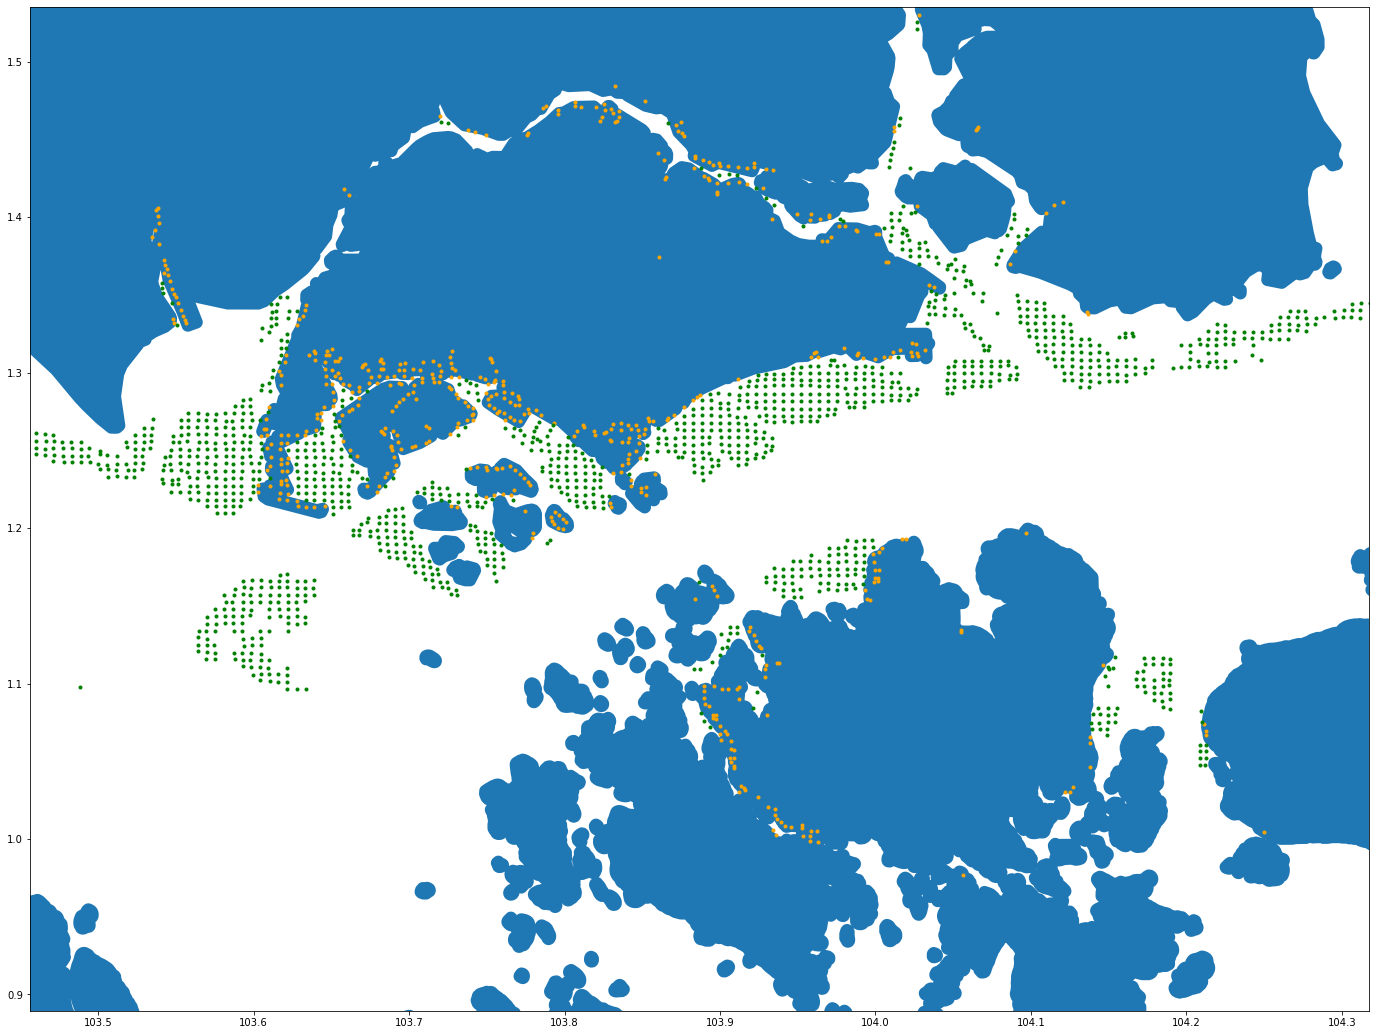

In [17]:
# singapore
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = 103.4563,0.8895,104.3177,1.5351
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=9)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=9)
plt.show()

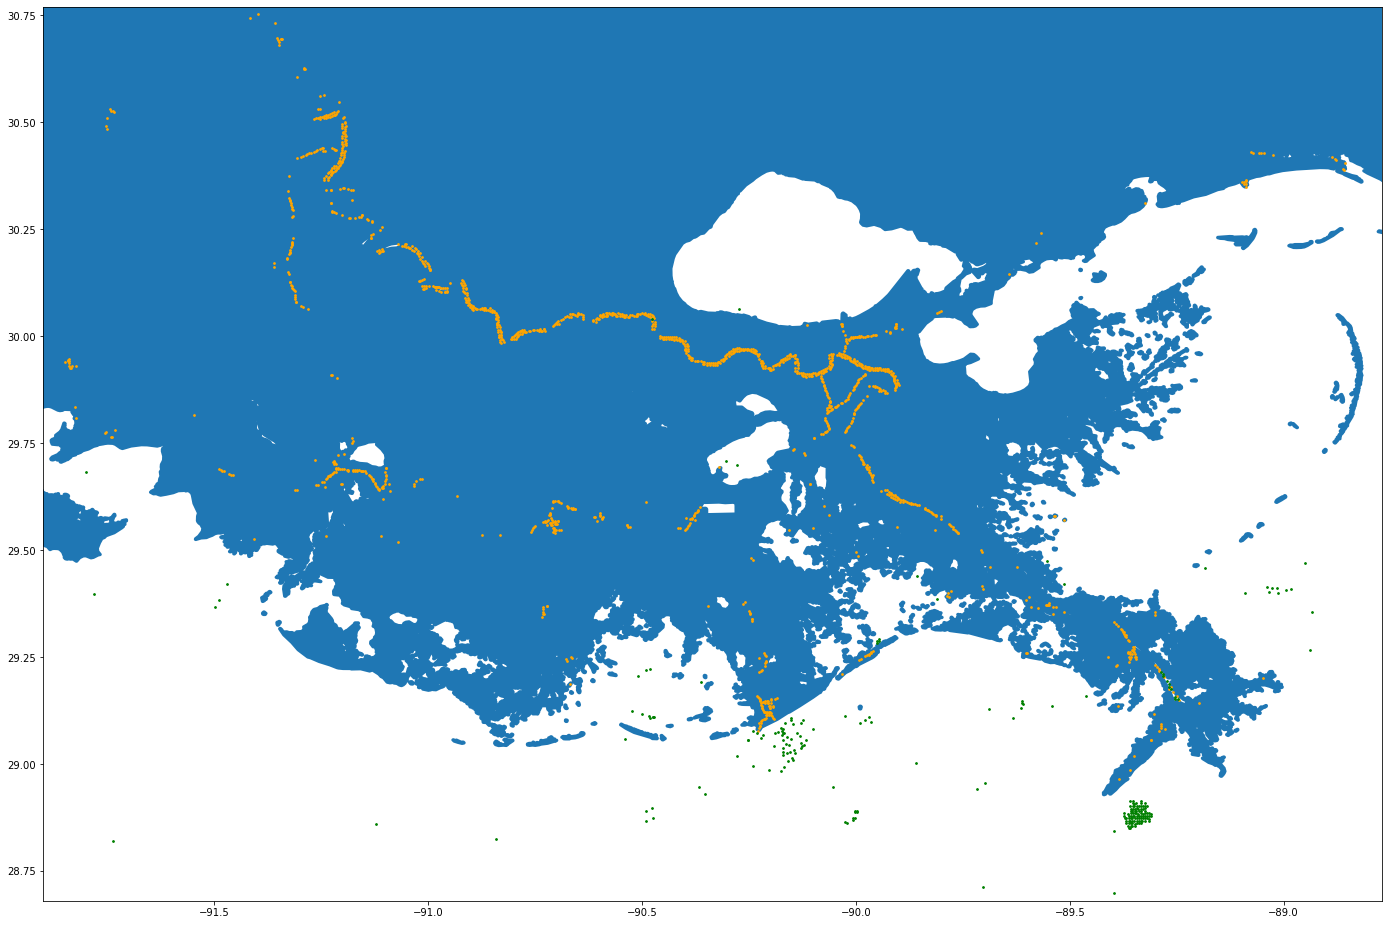

In [23]:
# mississippi
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = -91.9,28.68,-88.77,30.77
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=3)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=3)
plt.show()

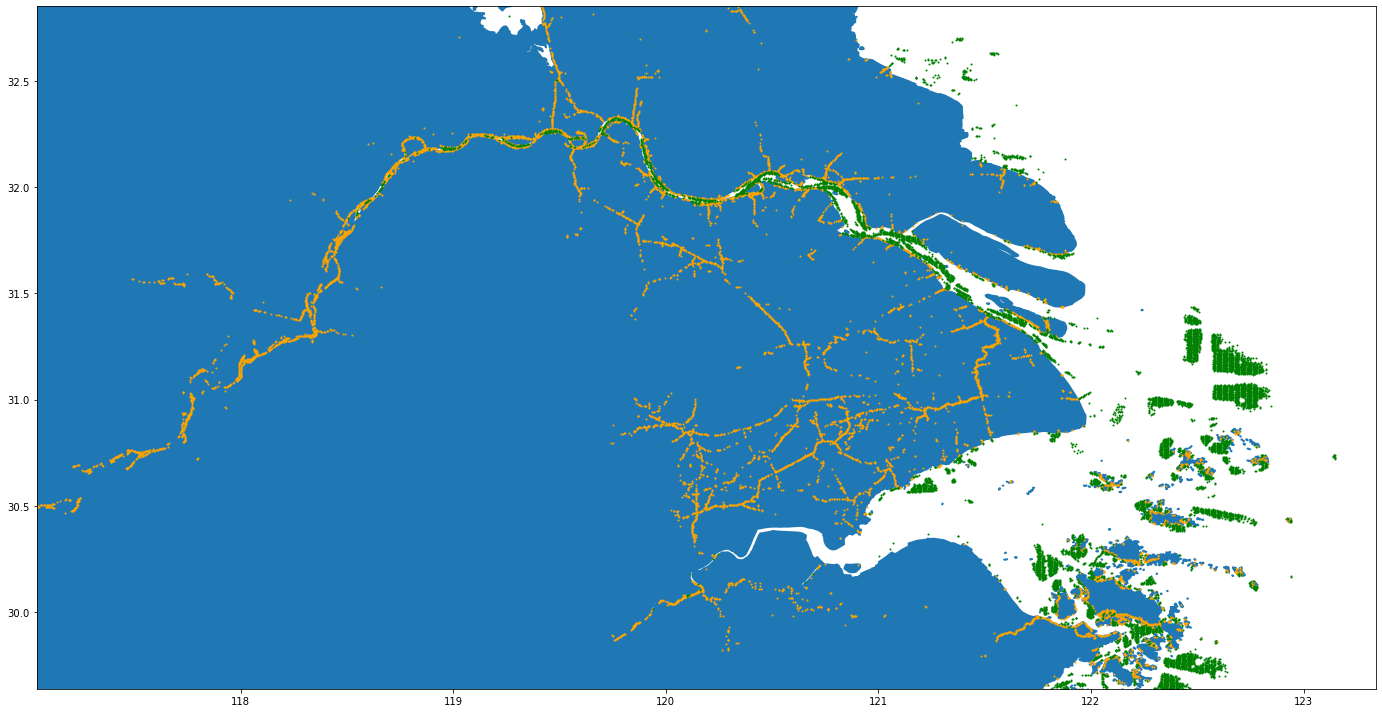

In [24]:
# shanghai up river
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = 117.04,29.64,123.34,32.85
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=1)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=1)
plt.show()

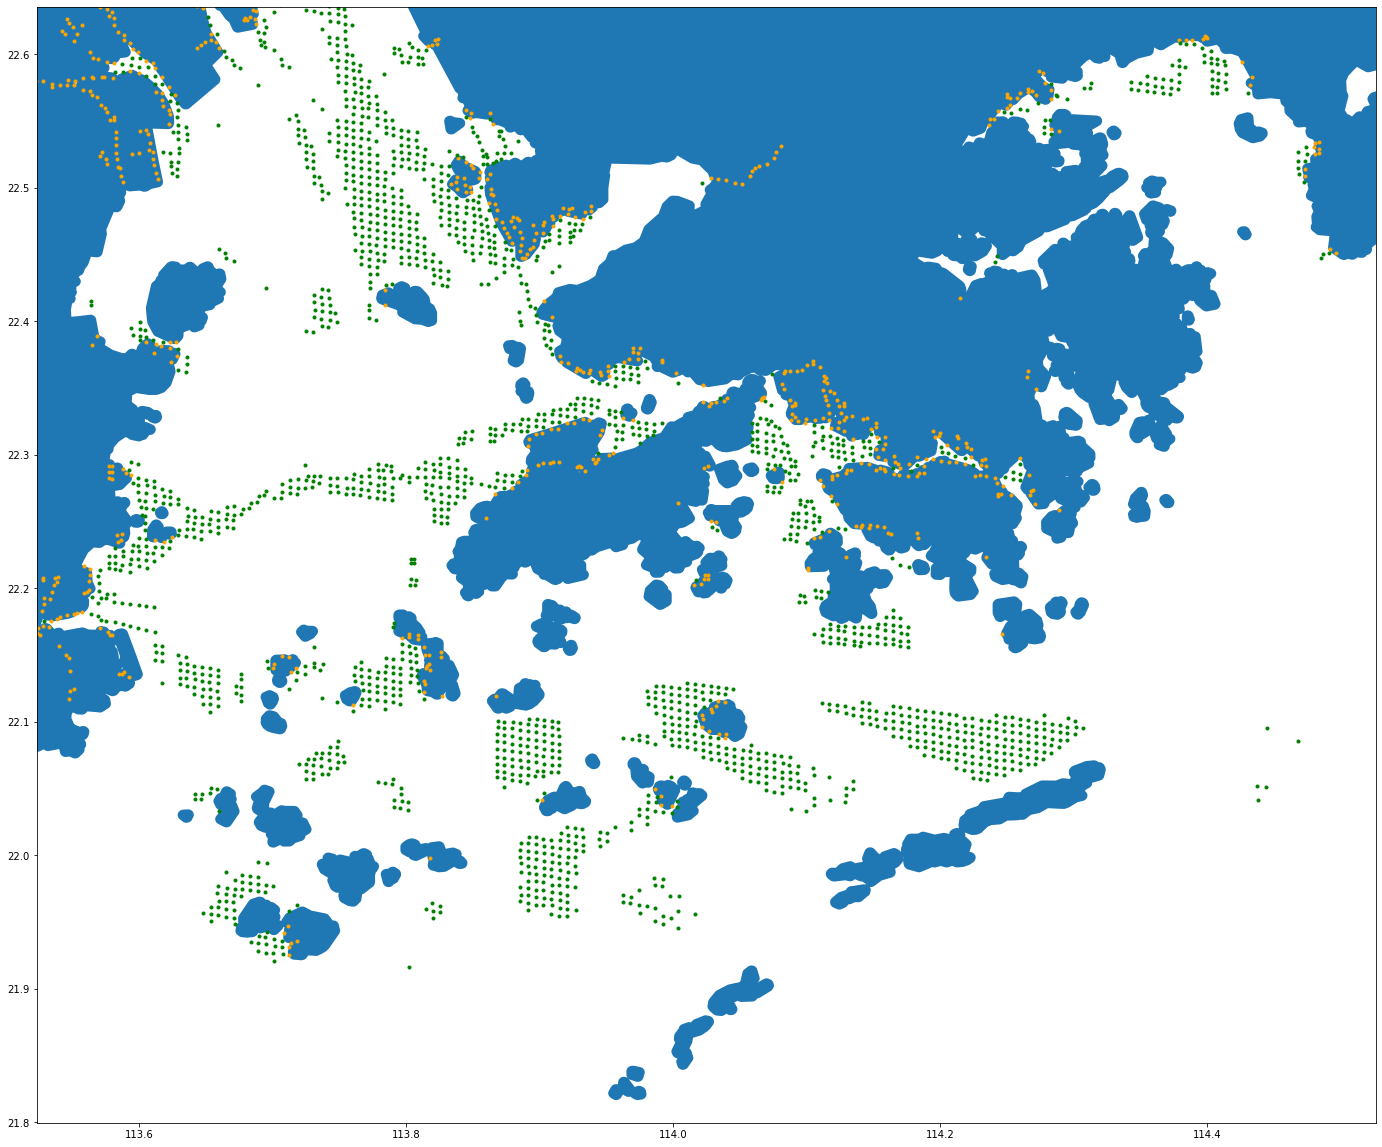

In [108]:
# hong kong
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = 113.5231,21.7994,114.5264,22.6356
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=9)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=9)
plt.show()

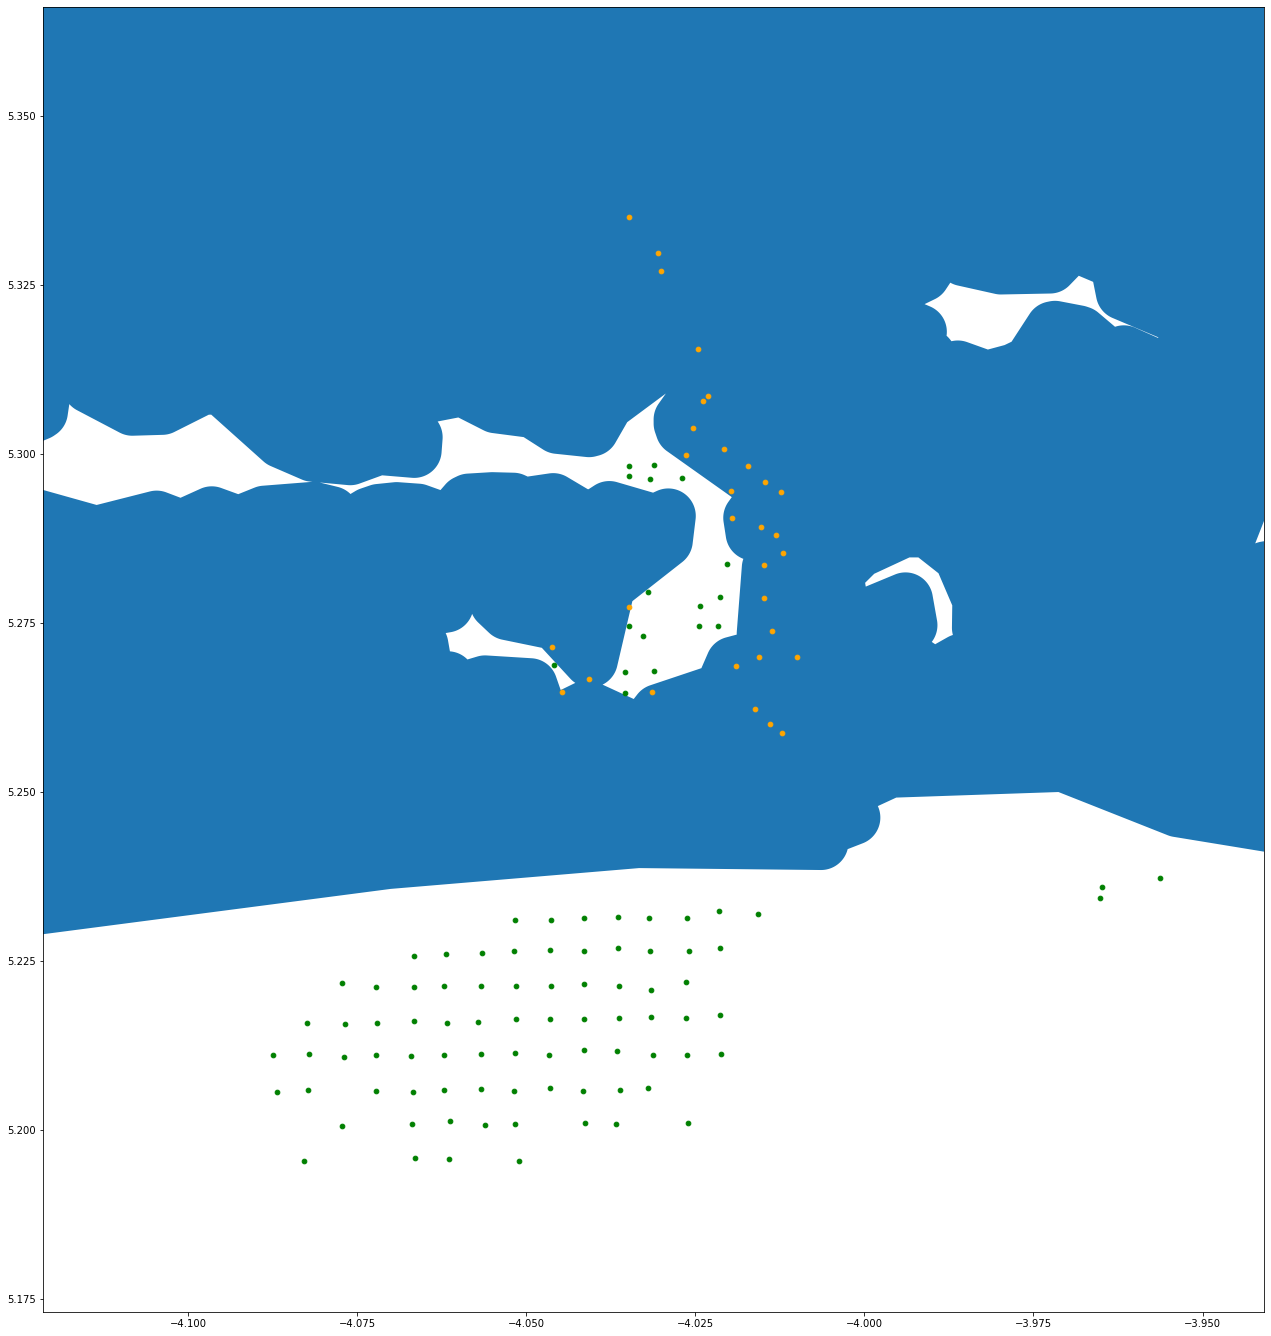

In [171]:
# abidjan
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = -4.121455,5.173169,-3.940917,5.366072
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=22)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=22)
plt.show()

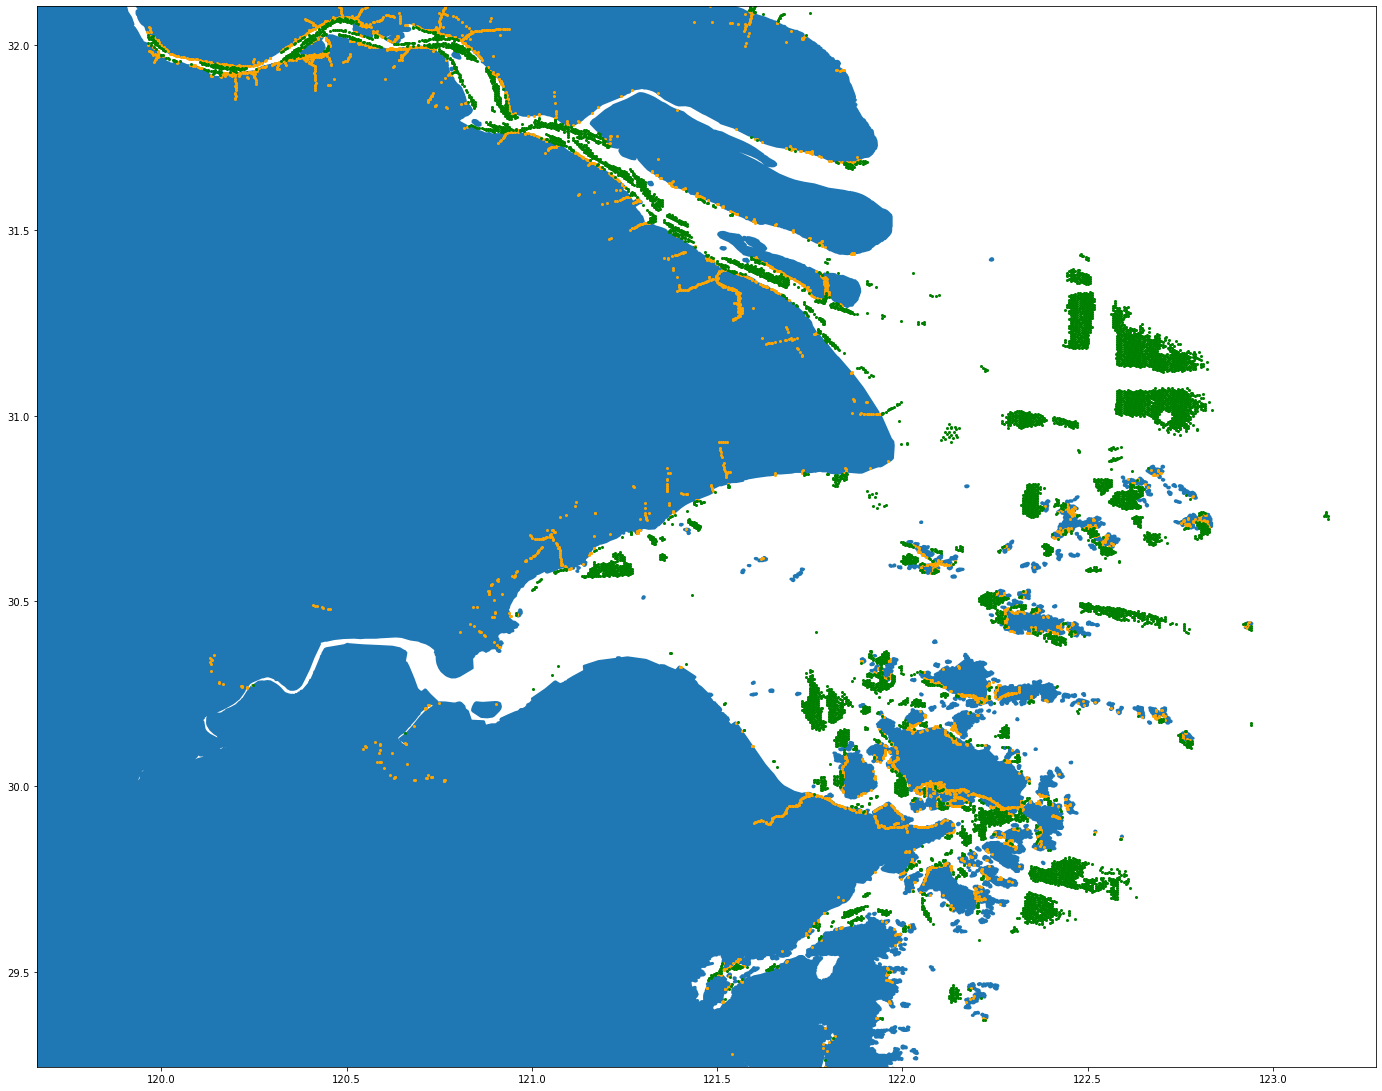

In [176]:
# shanghai
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = 119.6637,29.2433,123.2773,32.1047
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=4)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=4)
plt.show()

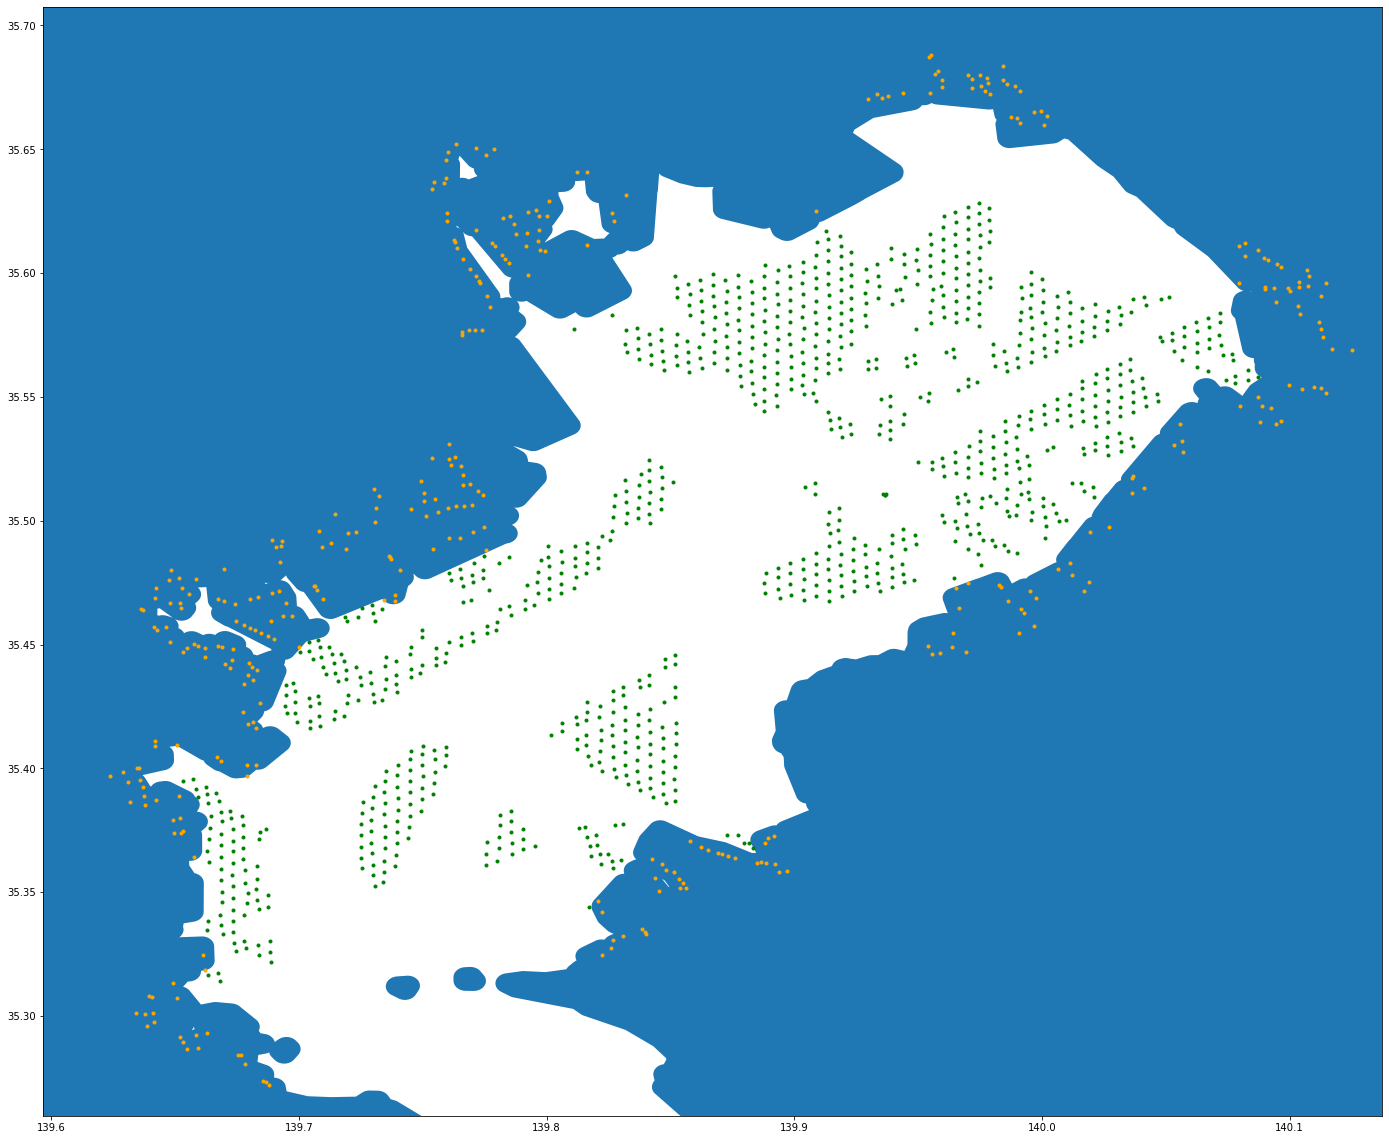

In [170]:
# tokyo
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = 139.5966,35.2597,140.1374,35.7075
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=9)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=9)
plt.show()

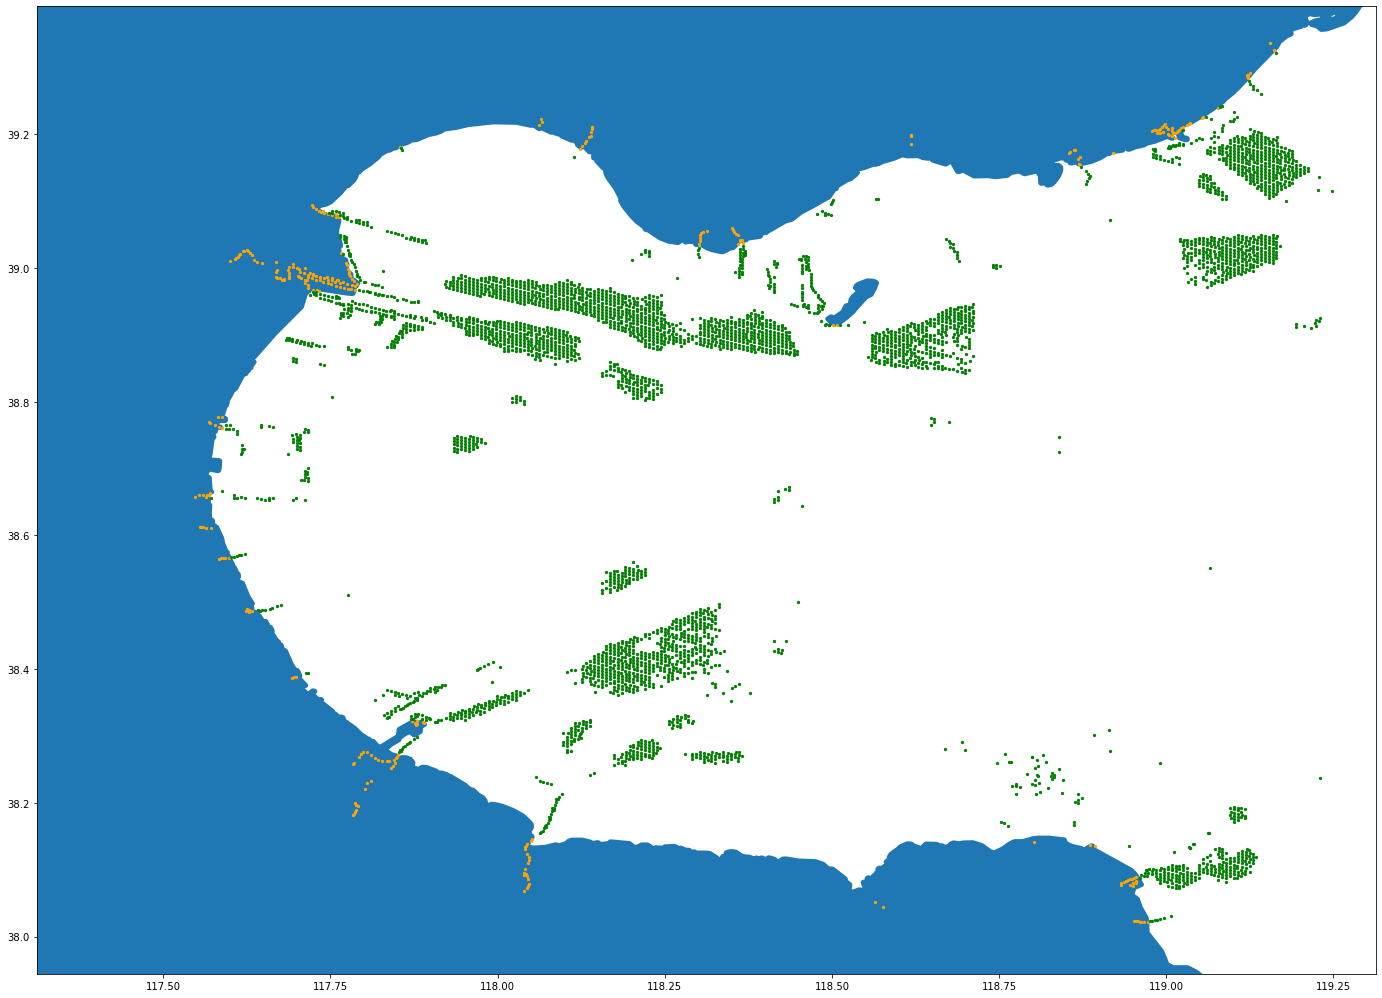

In [175]:
# tianjian
f, ax = plt.subplots(1, figsize=(24, 24))
minx, miny, maxx, maxy = 117.3104,37.9443,119.3134,39.3913
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax = shp.plot(axes=ax)
ax = gdf_TRUE.plot(axes=ax,color='orange',markersize=5)
ax = gdf_FALSE.plot(axes=ax,color='green',markersize=5)
plt.show()

## bq upload

Looks good so reconstruct df for bq upload with boolean `dock` labels

In [25]:
df

,lon,lat,s2id,geometry,index_right,id
0,-0.002632,5.575773,0fdf87f7,POINT (-0.002631714140233623 5.575772651438986),NaN,NaN
1,-0.002837,5.611992,0fdf877d,POINT (-0.002836546768035489 5.611992278080268),NaN,NaN
2,-0.002446,5.564589,0fdf87ff,POINT (-0.002445664645516772 5.564588915800534),NaN,NaN
3,-0.002103,5.543703,0fdf881f,POINT (-0.002103434770191745 5.543703413746935),NaN,NaN
4,-0.002547,5.559480,0fdf8801,POINT (-0.002547139171446937 5.559480341121514),NaN,NaN
5,-0.002153,5.569384,0fdf87f9,POINT (-0.002153248198822467 5.569384190718033),NaN,NaN
6,-0.002294,5.600907,0fdf8781,POINT (-0.002294264122762877 5.600906662780717),NaN,NaN
7,-0.002437,5.596130,0fdf8787,POINT (-0.002437113159281629 5.596130116854026),NaN,NaN
8,-0.002372,5.580215,0fdf87f5,POINT (-0.002372370519587585 5.580215414167341),NaN,NaN
9,-0.001878,5.585564,0fdf878b,POINT (-0.001878094220224475 5.58556407268548),NaN,NaN


In [26]:
df['dock'] = (df['id']==0.0)

In [27]:
df

,lon,lat,s2id,geometry,index_right,id,dock
0,-0.002632,5.575773,0fdf87f7,POINT (-0.002631714140233623 5.575772651438986),NaN,NaN,False
1,-0.002837,5.611992,0fdf877d,POINT (-0.002836546768035489 5.611992278080268),NaN,NaN,False
2,-0.002446,5.564589,0fdf87ff,POINT (-0.002445664645516772 5.564588915800534),NaN,NaN,False
3,-0.002103,5.543703,0fdf881f,POINT (-0.002103434770191745 5.543703413746935),NaN,NaN,False
4,-0.002547,5.559480,0fdf8801,POINT (-0.002547139171446937 5.559480341121514),NaN,NaN,False
5,-0.002153,5.569384,0fdf87f9,POINT (-0.002153248198822467 5.569384190718033),NaN,NaN,False
6,-0.002294,5.600907,0fdf8781,POINT (-0.002294264122762877 5.600906662780717),NaN,NaN,False
7,-0.002437,5.596130,0fdf8787,POINT (-0.002437113159281629 5.596130116854026),NaN,NaN,False
8,-0.002372,5.580215,0fdf87f5,POINT (-0.002372370519587585 5.580215414167341),NaN,NaN,False
9,-0.001878,5.585564,0fdf878b,POINT (-0.001878094220224475 5.58556407268548),NaN,NaN,False


In [28]:
df = df.drop(columns=['index_right','id'])

In [29]:
df.head()

,lon,lat,s2id,geometry,dock
0,-0.002632,5.575773,0fdf87f7,POINT (-0.002631714140233623 5.575772651438986),False
1,-0.002837,5.611992,0fdf877d,POINT (-0.002836546768035489 5.611992278080268),False
2,-0.002446,5.564589,0fdf87ff,POINT (-0.002445664645516772 5.564588915800534),False
3,-0.002103,5.543703,0fdf881f,POINT (-0.002103434770191745 5.543703413746935),False
4,-0.002547,5.559480,0fdf8801,POINT (-0.002547139171446937 5.559480341121514),False


In [30]:
len(df.query('dock == False'))

87962

In [31]:
len(df.query('dock == True'))

78545

In [32]:
print(len(df.query('dock == True'))/len(df))

0.47172190958938665


In [33]:
df.to_gbq('scratch_brian.anchorages_dock_label', project_id='world-fishing-827', if_exists='replace')